<span style="font-size: 48px;">Step 1: Imports</span>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import to_categorical
from datetime import datetime

<span style="font-size: 48px;">Step 2: Data Importing</span>

In [2]:
def load_data(data_dir, IMG_WIDTH, IMG_HEIGHT):
    images = []
    labels = []

    categories = os.listdir(data_dir)
    categories.remove(".DS_Store")
    categories = [int(s) for s in categories]
    categories.sort()

    for category in categories:
        # if category == ".DS_Store":
        #         continue
        category_dir = os.path.join(data_dir, str(category))
        print(f"\nLoading images from category {category}")

        for filename in os.listdir(category_dir):
            if filename.endswith(".jpg") or filename.endswith(".ppm"):
                img_path = os.path.join(category_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                
                images.append(img)
                labels.append(category)

        print(len(images))

    return (np.array(images), np.array(labels))

In [3]:
data_dir = "gtsrb"
IMG_HEIGHT = 30
IMG_WIDTH = 30

images, labels = load_data(data_dir, IMG_HEIGHT, IMG_WIDTH)


Loading images from category 0
150

Loading images from category 1
1650

Loading images from category 2
3150

Loading images from category 3
4110

Loading images from category 4
5430

Loading images from category 5
6690

Loading images from category 6
6990

Loading images from category 7
7950

Loading images from category 8
8910

Loading images from category 9
9900

Loading images from category 10
11250

Loading images from category 11
12150

Loading images from category 12
13560

Loading images from category 13
15000

Loading images from category 14
15540

Loading images from category 15
15960

Loading images from category 16
16260

Loading images from category 17
17010

Loading images from category 18
17820

Loading images from category 19
17970

Loading images from category 20
18210

Loading images from category 21
18450

Loading images from category 22
18720

Loading images from category 23
19080

Loading images from category 24
19260

Loading images from category 25
20280

Loadin

In [4]:
# for image in images:
#     cv2.imshow('Image Window', image)
#     cv2.waitKey(0)
# cv2.destroyAllWindows()

In [5]:
print(images.shape)
# print(images[0])

(26640, 30, 30, 3)


In [6]:
reshaped_images = images.reshape(images.shape[0], -1)
print(reshaped_images.shape)

(26640, 2700)


<span style="font-size: 48px;">Step 3: Feature Scaling</span>

In [7]:
standard_scaler = StandardScaler()
X_standard = pd.DataFrame(standard_scaler.fit_transform(reshaped_images))

print("StandardScaler - Training Data Stats:")
print(X_standard.describe())

StandardScaler - Training Data Stats:
               0             1             2             3             4     \
count  2.664000e+04  2.664000e+04  2.664000e+04  2.664000e+04  2.664000e+04   
mean   1.024206e-16  3.200643e-17 -4.907653e-17  1.109556e-16  9.815305e-17   
std    1.000019e+00  1.000019e+00  1.000019e+00  1.000019e+00  1.000019e+00   
min   -1.108157e+00 -1.091088e+00 -1.118915e+00 -1.068765e+00 -1.090915e+00   
25%   -7.473345e-01 -7.653947e-01 -7.664905e-01 -7.472316e-01 -7.655620e-01   
50%   -4.509447e-01 -4.006176e-01 -4.010130e-01 -4.514205e-01 -4.141812e-01   
75%    4.897707e-01  4.982974e-01  5.126808e-01  4.874583e-01  4.968061e-01   
max    2.165017e+00  2.178877e+00  2.157330e+00  2.159434e+00  2.175625e+00   

               5             6             7             8             9     \
count  2.664000e+04  2.664000e+04  2.664000e+04  2.664000e+04  2.664000e+04   
mean   2.133762e-18 -2.987267e-17  1.963061e-16  6.828038e-17  1.066881e-17   
std    1.0000

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_standard, labels, test_size=0.4, random_state=35)

X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5, random_state=35)

print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\nX_cv shape: {X_cv.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}\ny_cv shape: {y_cv.shape}")

X_train shape: (15984, 2700)
X_test shape: (5328, 2700)
X_cv shape: (5328, 2700)
y_train shape: (15984,)
y_test shape: (5328,)
y_cv shape: (5328,)


In [9]:
# one-hot encoding

num_classes = len(np.unique(y_test))
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot  = to_categorical(y_test,    num_classes)
y_cv_onehot    = to_categorical(y_cv,    num_classes)

<span style="font-size: 48px;">Step 5: Model Training and Evaluation</span>

In [10]:
# hyperparemeter tuning

tf.random.set_seed(42)
np.random.seed(42)

best_val_loss = float('inf')
best_config = None

column_names = ['units', 'l2_value', 'hidden_function', 'epochs', 'val_loss', 'val_acc']
df = pd.DataFrame(columns = column_names)

for units in [16, 32, 64, 128]:
    for l2_val in [.0, .001, .01]:
        for hidden_function in ['relu']:
            for epochs in [25, 50, 75, 100]:
                print(f"Testing:\nUnits: {units}, L2: {l2_val}, Hidden Function: {hidden_function}, Epochs: {epochs}")
                model = Sequential([
                    tf.keras.Input(shape = (X_train.shape[1],)),
                    Dense(units, activation=hidden_function, kernel_regularizer=l2(l2_val)),
                    Dense(units//2, activation=hidden_function, kernel_regularizer=l2(l2_val)),
                    Dense(43, activation='linear')
                ])

                model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                            optimizer = tf.keras.optimizers.Adam(0.001),
                            metrics = ['accuracy'])

                history = model.fit(
                    X_train, y_train_onehot, validation_data = (X_cv, y_cv_onehot), epochs = epochs, verbose = 0, shuffle=True
                )

                val_loss = history.history['val_loss'][-1]
                val_acc = history.history['val_accuracy'][-1]
                
                config = [units, l2_val, hidden_function, epochs, val_loss, val_acc]

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_config = config
                    best_model = tf.keras.models.clone_model(model)
                    best_model.set_weights(model.get_weights())
                    best_history = history
                    print(f"{'-'*13} New Best! {'-'*13}")

                print(f"   → Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

                print(f"Current Best Config: units={best_config[0]}, l2={best_config[1]}, func='{best_config[2]}', epochs={best_config[3]}, val_loss={best_config[4]:.4f}, val_acc={best_config[5]:.4f}\n")

                df.loc[len(df)] = config
            

Testing:
Units: 16, L2: 0.0, Hidden Function: relu, Epochs: 25
------------- New Best! -------------
   → Val Loss: 0.4425, Val Acc: 0.8928

Current Best Config: units=16, l2=0.0, func='relu', epochs=25, val_loss=0.4425, val_acc=0.8928

Testing:
Units: 16, L2: 0.0, Hidden Function: relu, Epochs: 50
   → Val Loss: 0.4638, Val Acc: 0.9024

Current Best Config: units=16, l2=0.0, func='relu', epochs=25, val_loss=0.4425, val_acc=0.8928

Testing:
Units: 16, L2: 0.0, Hidden Function: relu, Epochs: 75
   → Val Loss: 0.5005, Val Acc: 0.9071

Current Best Config: units=16, l2=0.0, func='relu', epochs=25, val_loss=0.4425, val_acc=0.8928

Testing:
Units: 16, L2: 0.0, Hidden Function: relu, Epochs: 100
   → Val Loss: 0.6308, Val Acc: 0.8958

Current Best Config: units=16, l2=0.0, func='relu', epochs=25, val_loss=0.4425, val_acc=0.8928

Testing:
Units: 16, L2: 0.001, Hidden Function: relu, Epochs: 25
   → Val Loss: 0.6654, Val Acc: 0.8694

Current Best Config: units=16, l2=0.0, func='relu', epochs=2

In [11]:
averages_df = df.drop("val_loss", axis = 1)
averages_df = averages_df.drop("val_acc", axis = 1)
for column in averages_df.columns:
    print(f"Average by {column}:")
    print(f"{df.groupby(column)['val_loss'].mean()}\n")

print(f"\nBest Config: units={best_config[0]}, l2={best_config[1]}, func='{best_config[2]}', epochs={best_config[3]}, val_loss={best_config[4]:.4f}, val_accuracy={best_config[5]:.4f}")

best_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
best_model.build(input_shape=(None, X_train.shape[1]))
test_loss, test_acc = best_model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Best model test accuracy: {test_acc:.4f}")

Average by units:
units
16     0.710576
32     0.601263
64     0.584315
128    0.625847
Name: val_loss, dtype: float64

Average by l2_value:
l2_value
0.000    0.420925
0.001    0.597012
0.010    0.873565
Name: val_loss, dtype: float64

Average by hidden_function:
hidden_function
relu    0.6305
Name: val_loss, dtype: float64

Average by epochs:
epochs
25     0.664831
50     0.597415
75     0.605437
100    0.654318
Name: val_loss, dtype: float64


Best Config: units=64, l2=0.0, func='relu', epochs=50, val_loss=0.2587, val_accuracy=0.9538
Best model test accuracy: 0.9523


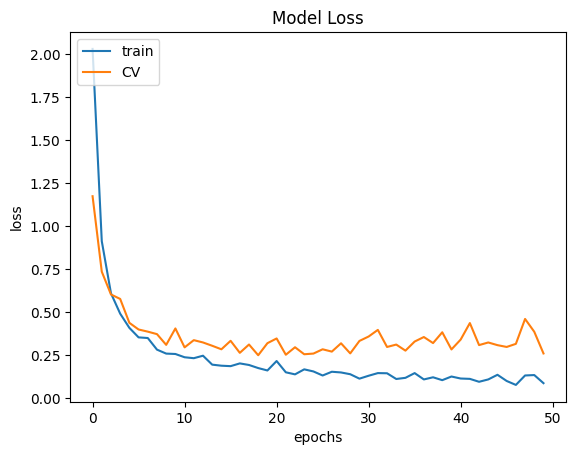

In [12]:
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'CV'], loc = 'upper left')
plt.show()

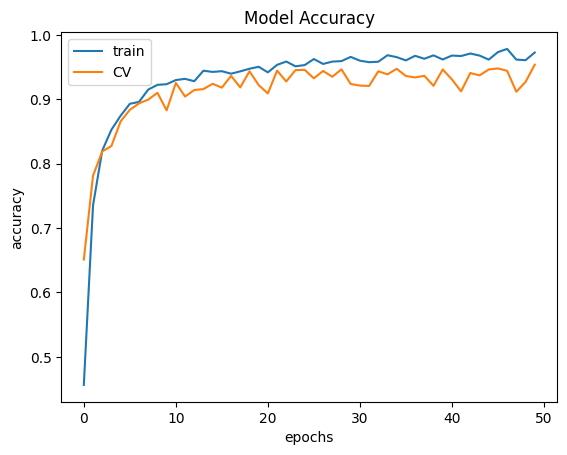

In [13]:
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'CV'], loc = 'upper left')
plt.show()

In [14]:
current_datetime = datetime.now()
os.mkdir(f"{current_datetime}")
best_model.save(f"{current_datetime}/{test_loss:.4f}_{test_acc:.4f}.keras")
np.save(f'{current_datetime}/y_test_onehot.npy', y_test_onehot)
X_test.to_csv(f'{current_datetime}/X_test.csv')